<a href="https://colab.research.google.com/github/2024-WISET-F16/wiset-ai-models/blob/kwakminjung%2Fmodels/kwakminjung/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-5-45c4106d1502>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_dataset['azimuth'] = training_dataset['azimuth'].astype(float)
<ipython-input-5-45c4106d1502>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_dataset['elevation'] = training_dataset['elevation'].astype(float)


linear_stack Parameter containing:
tensor([[-0.0730,  0.2763, -0.3430,  0.0810, -0.0540],
        [-0.0383,  0.0010, -0.0044, -0.3209, -0.2620],
        [-0.3803,  0.0683, -0.1328,  0.1064,  0.1304],
        [-0.3511, -0.3799,  0.2430, -0.2170,  0.1854],
        [ 0.1679, -0.1296, -0.0439, -0.2483, -0.2231],
        [ 0.3692, -0.2269,  0.0989,  0.3394, -0.2207]], requires_grad=True)
linear_stack Parameter containing:
tensor([ 0.3492, -0.3408, -0.4042,  0.2322, -0.0217,  0.3071],
       requires_grad=True)
epoch = 0, current loss = 126406.5391
epoch = 0, current test loss = 135396.4844
epoch = 100, current loss = 173.6241
epoch = 100, current test loss = 272.5327
epoch = 200, current loss = 133.0456
epoch = 200, current test loss = 139.0799
epoch = 300, current loss = 125.1219
epoch = 300, current test loss = 119.7124
epoch = 400, current loss = 119.4907
epoch = 400, current test loss = 103.6726
epoch = 500, current loss = 115.2676
epoch = 500, current test loss = 90.1327
epoch = 600, c

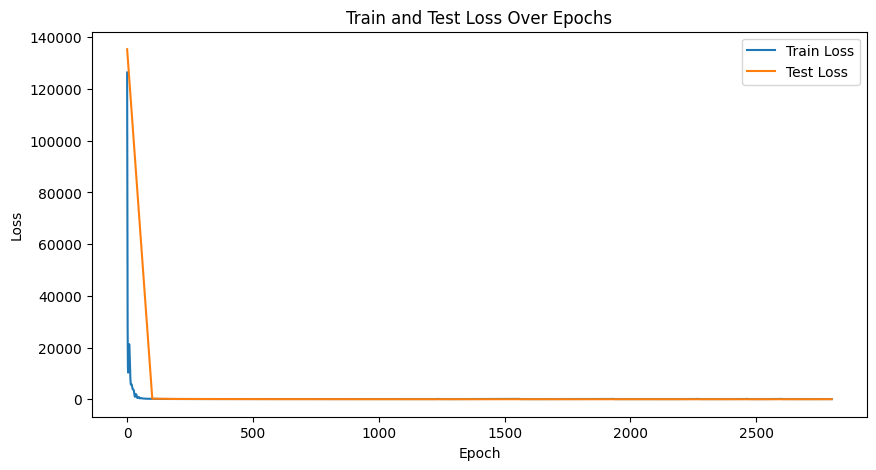

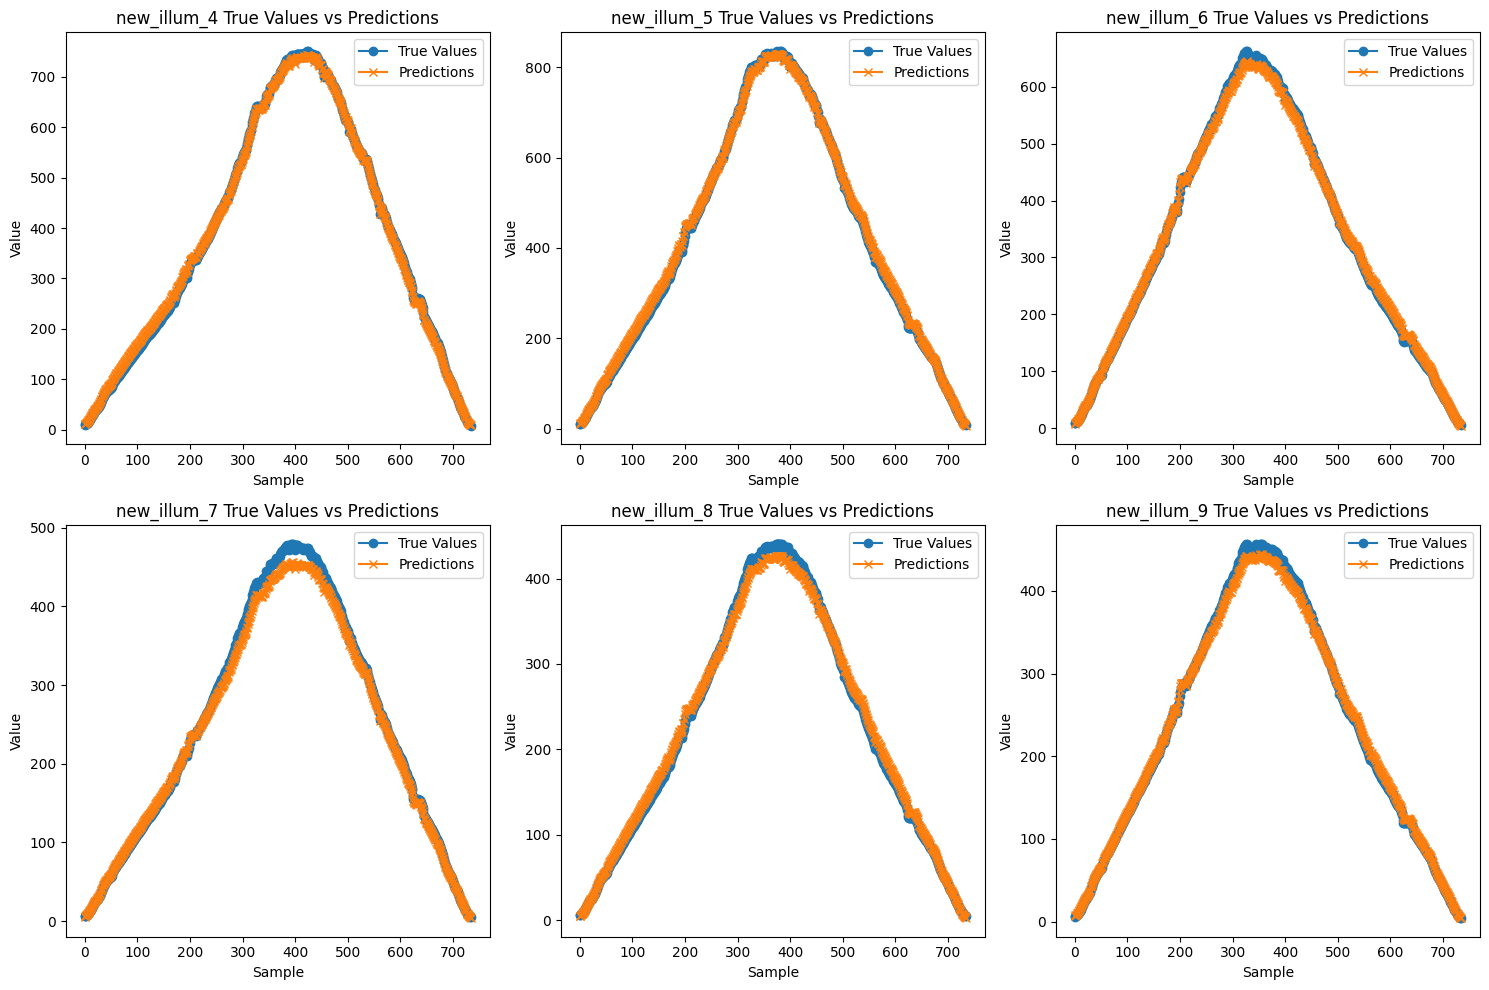

new_illum_4 mean absolute error: 5.540048599243164
new_illum_5 mean absolute error: 6.931328296661377
new_illum_6 mean absolute error: 5.826201915740967
new_illum_7 mean absolute error: 7.608288288116455
new_illum_8 mean absolute error: 6.528738021850586
new_illum_9 mean absolute error: 5.031835079193115
total mae: 6.244406700134277
[[10.671677  10.731685   8.175083   5.724534   4.365296   6.677219 ]
 [11.925255  12.275952   9.445082   6.544853   5.178409   7.546692 ]
 [13.101856  13.707474  10.622894   7.31297    5.9352226  8.3550205]
 ...
 [10.313696   9.389268   6.437389   5.2954855  3.6560416  5.6593223]
 [ 9.215918   8.211142   5.56229    4.6115303  3.0303357  5.029718 ]
 [ 8.20103    7.0798187  4.7251706  3.974724   2.4370883  4.4321356]]


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from openpyxl import Workbook

training_dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/wiset_train_data_20240329-20240513.xlsx')
test_dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/wiset_test_data_20240407.xlsx')

# test_dataset 복사 (datetime 포함 복사)
test_dataset_copy = test_dataset.copy()

# training dataset 준비
# azimuth or elevation 'dark' 일 경우 제외
mask = ~(training_dataset['azimuth'].str.contains('dark') | training_dataset['elevation'].str.contains('dark'))
training_dataset = training_dataset[mask]

training_dataset['azimuth'] = training_dataset['azimuth'].astype(float)
training_dataset['elevation'] = training_dataset['elevation'].astype(float)

X_train_pd = training_dataset.iloc[:, 1:6]
y_train_pd = training_dataset.iloc[:, 6:]

# 결측값 제거
X_train_pd = X_train_pd.dropna()
y_train_pd = y_train_pd.dropna()

# ===================

X_train_np = X_train_pd.astype(np.float32).to_numpy()
X_train_np[:, 0] = abs(X_train_np[:, 0] - 180)

y_train_np = y_train_pd.astype(np.float32).to_numpy()

X_train = torch.Tensor(X_train_np).float()
y_train = torch.Tensor(y_train_np).float()

# test dataset 준비
X_test_pd = test_dataset.iloc[:, 1:6]
X_test_np = X_test_pd.astype(np.float32).to_numpy()
X_test_np[:, 0] = abs(X_test_np[:, 0] - 180)

X_test = torch.Tensor(X_test_np).float()

y_test_pd = test_dataset.iloc[:, 6:]
y_test_np = y_test_pd.astype(np.float32).to_numpy()

y_test = torch.Tensor(y_test_np).float()

# ====================

# 선형회귀 모델
class MyLinearRegressionModel(nn.Module):

  def __init__(self, input_nodes, output_nodes):
    super().__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(input_nodes, output_nodes)
    )

  def forward(self, data):
    prediction = self.linear_stack(data)

    return prediction

# input_nodes: 5, ouput: 6
model = MyLinearRegressionModel(5, 6)

# w1,w2,w3,w4,w5 and bias
for name, child in model.named_children():
  for param in child.parameters():
    print(name, param)

# loss function (mean square)
loss_function = nn.MSELoss()

# optimizer: Adam optimizer 사용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

# 조기 종료 변수 초기화
early_stopping_epochs = 5
best_loss = float('inf')
early_stop_cnt = 0

train_loss_list = []
test_loss_list = []
nums_epoch = 10000
eval_interval = 100

for epoch in range(nums_epoch + 1):
  model.train()

  # loss function 계산
  prediction = model(X_train)
  loss = loss_function(prediction, y_train)

  train_loss_list.append(loss.item())

  # 역전파
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if epoch % eval_interval == 0:
    print(f'epoch = {epoch}, current loss = {loss.item():.4f}')

    # test의 loss 계산
    model.eval()
    with torch.no_grad():
      test_predictions = model(X_test)
      test_loss = loss_function(test_predictions, y_test)
      test_loss_list.append(test_loss.item())

      print(f'epoch = {epoch}, current test loss = {test_loss.item():.4f}')

      # 조기 종료 조건 검사
      if test_loss < best_loss:
        best_loss = test_loss
        early_stop_cnt = 0
      else:
        early_stop_cnt += 1

      if early_stop_cnt >= early_stopping_epochs:
        print(f'Early stopping at epoch {epoch}')
        break

print(f'Final train loss: {train_loss_list[-1]:.4f}')
print(f'Final test loss: {test_loss_list[-1]:.4f}')

# loss function plot
plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss_list)), train_loss_list, label='Train Loss')
plt.plot(range(0, len(train_loss_list), eval_interval), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss Over Epochs')
plt.legend()
plt.show()

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(6):
    ax = axs[i // 3, i % 3]
    ax.plot(y_test_np[:, i], label='True Values', marker='o')
    ax.plot(test_predictions.numpy()[:, i], label='Predictions', marker='x')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Value')
    ax.set_title(f'new_illum_{i + 4} True Values vs Predictions')
    ax.legend()

plt.tight_layout()
plt.show()

test_predictions_np = test_predictions.numpy()

total_mae = 0
for i in range(6):
    mae = mean_absolute_error(y_test_np[:, i], test_predictions_np[:, i])
    print(f'new_illum_{i + 4} mean absolute error: {mae}')
    total_mae += mae

print(f'total mae: {total_mae / 6}')
print(test_predictions_np)

# 예측값
predicted_values = {
    'predicted_new_illum_4': test_predictions_np[:, 0],
    'predicted_new_illum_5': test_predictions_np[:, 1],
    'predicted_new_illum_6': test_predictions_np[:, 2],
    'predicted_new_illum_7': test_predictions_np[:, 3],
    'predicted_new_illum_8': test_predictions_np[:, 4],
    'predicted_new_illum_9': test_predictions_np[:, 5],
}

# 예측값을 test_dataset_copy에 추가
for key, value in predicted_values.items():
    test_dataset_copy[key] = value

# Workbook 객체 생성
wb = Workbook()

# 현재 활성화된 워크시트 선택 후 ws 변수에 할당
ws = wb.active

# 시트 제목
ws.title = "Predicted values"

# 컬럼 헤더 추가
column = ['datetime', 'azimuth', 'elevation', 'new_illum_10', 'new_illum_11', 'new_illum_12', 'new_illum_4', 'new_illum_5', 'new_illum_6', 'new_illum_7', 'new_illum_8', 'new_illum_9','predicted_new_illum_4', 'predicted_new_illum_5', 'predicted_new_illum_6', 'predicted_new_illum_7','predicted_new_illum_8', 'predicted_new_illum_9']
ws.append(column)

# 데이터 추가
for index, row in test_dataset_copy.iterrows():
    ws.append(list(row))

# 엑셀 파일 저장
wb.save('/content/drive/MyDrive/Colab Notebooks/predicted_values.xlsx')